In [1]:
from datetime import datetime
import dask.array as da
import os
import glob
import time
import h5py
import pandas as pd
import numpy as np
import xarray as xr
import downscale as down
import matplotlib.pyplot as plt

import warnings

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

In [2]:
name, yy_s, yy_e = 'Coast Level', 2008, 2012
YEARS = np.arange(yy_s, yy_e + 1)

In [3]:
base_dir = os.path.join('/','home','arturo','github','downpy','data')

In [4]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0 # Earth radius in kilometers
    
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

In [5]:
extract_box = True # do it only once
# inputfile = os.path.join('..', cdat.tmpa_dir, 'data_tmpa_3h.hdf5')
tmpa_dir = os.path.join('..', 'data', 'tmpa_conus_data')
inputfile = os.path.join('..','data','tmpa_conus_data',f'data_tmpa_3h_2008_2012.nc')
outputdir = os.path.join('..', 'data', 'sample_data')

dx = 0.25
npix = 3

In [6]:
f = xr.open_dataset(inputfile)
tmpalat = f['lat'][:]
tmpalon = f['lon'][:]
dates = f['time'][:]
dset = f['PRE']

# ======================================================================
# # ATENTION: daily data, aprox 6 min
# dset = dset.resample(time ='D').sum(dim='time', skipna=False)
# dates = dset['time']
# ======================================================================

print('dataset shape = {}'.format(dset.shape)) # too large to fit in memory!

dataset shape = (280, 112, 14615)


In [7]:
x = da.from_array(dset, chunks=(6, 6, 300))
xrs = xr.DataArray(x,  coords={'lon':tmpalon, 'lat':tmpalat, 'time':dates},
                                                dims=('lon', 'lat', 'time'))
# xrs = xrs0.where(xrs0 >= -0.001)

In [8]:
Tr = 100

maxmiss = 200 # maximum limit of NaN values in TRMM

res = {}  # initialize dictionary for storing results

In [9]:
DATA = h5py.File(inputfile, "r")
ALL_lat = DATA['lat'][:]
ALL_lon = DATA['lon'][:]
lon2d, lat2d = np.meshgrid(ALL_lon, ALL_lat)
del DATA

## Load Raingauge

In [10]:
file_list = glob.glob(os.path.join(base_dir, 'data_noaa_hpd_gauges', 'daily_csv', '*.csv'))
file_list = sorted(file_list)
len_list = len(file_list)
print(f'NUmber of files: {len_list}')

list_names = []
for nn in range(len_list):
    tmp = file_list[nn].split('/')[-1].split('.')[0]
    list_names.append(tmp)

data_dir = os.path.join(base_dir, 'data_noaa_hpd_gauges', 'HOURLY_LOC_NYEARS.csv')
INFO = pd.read_csv(data_dir)

NUmber of files: 1928


In [11]:
lo_limit_min, lo_limit_max, la_limit_min, la_limit_max = -90, -80, 30, 35

In [12]:
lat_rain = []
lon_rain = []
id_rain = []
for nn in range(len(list_names)):
    TEST = INFO[INFO['ID']==list_names[nn]]
    lat_rain.append(TEST['LAT'].values[0])
    lon_rain.append(TEST['LON'].values[0])
    id_rain.append(TEST['ID'].values[0])

lat_rain = np.array(lat_rain)
lon_rain = np.array(lon_rain)
id_rain = np.array(id_rain)


lat_bnds = np.where((lat_rain>=la_limit_min)&(lat_rain<=la_limit_max))[0]

lat_rain = lat_rain[lat_bnds]
lon_rain = lon_rain[lat_bnds]
id_rain = id_rain[lat_bnds]

lon_bnds = np.where((lon_rain>=lo_limit_min)&(lon_rain<=lo_limit_max))[0]

lat_rain = lat_rain[lon_bnds]
lon_rain = lon_rain[lon_bnds]
id_rain = id_rain[lon_bnds]

## Choose station

In [13]:
pos_ref = 12
# pos_ref = 22
pos_ref = 10

RAIN_lat = lat_rain[pos_ref]
RAIN_lon = lon_rain[pos_ref]
cid = id_rain[pos_ref]

In [14]:
input_dir = os.path.join(base_dir,'data_noaa_hpd_gauges','daily_csv',f'{cid}.csv')
RAIN = pd.read_csv(input_dir)

RAIN = RAIN[(RAIN['YEAR']>=yy_s)&(RAIN['YEAR']<=yy_e)]

RAIN=RAIN.mask(RAIN==np.min(RAIN['PRCP'])).fillna(0)

datetime_OBS = pd.to_datetime(RAIN['DATE'].values, format='%Y%m%d')

RAIN.head(3)

,Unnamed: 0,DATE,YEAR,PRCP
7666,7666,20080101,2008,0.0
7667,7667,20080102,2008,0.0
7668,7668,20080103,2008,0.0


In [15]:
print(f'Start time: {RAIN['DATE'].values[0]}')
print(f'End time  : {RAIN['DATE'].values[len(RAIN)-1]}')

Start time: 20080101
End time  : 20121231


In [16]:
OBS = xr.DataArray(RAIN['PRCP'].values,  coords={'time':datetime_OBS}, dims=('time'))
NCW_1dy, YEARS_OBS = down.fit_yearly_weibull(OBS, thresh=1, maxmiss=maxmiss)

In [17]:
distances = haversine(lat2d, lon2d, RAIN_lat, RAIN_lon)
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

clat = ALL_lat[min_index[0]]
clon = ALL_lon[min_index[1]]

TRMM_ML = dset[min_index[1],min_index[0],:] # lon, lat, time

print(f"Nearest IMERG lat: {clat}")
print(f'Station lat       : {RAIN_lat}')
print()
print(f"Nearest IMERG lon: {clon}")
print(f'Station lon       : {RAIN_lon}')

Nearest IMERG lat: 34.875
Station lat       : 34.9786

Nearest IMERG lon: -85.875
Station lon       : -85.8008


In [18]:
YEARS_update = []
for yy in YEARS:
    DATA_TMP = TRMM_ML.sel(time=TRMM_ML.time.dt.year.isin([yy])).data
    if len(DATA_TMP[np.isnan(DATA_TMP)==True]) > maxmiss:
        print(f'{int(yy)} is incomplete, has {len(DATA_TMP[np.isnan(DATA_TMP)==True])}')

    else:
        print(yy, len(np.where(np.isnan(DATA_TMP))[0]))
        YEARS_update.append(yy)

2008 102
2009 194
2010 0
2011 0
2012 0


In [19]:
TRMM_ML_1dy = TRMM_ML.resample(time ='D').sum(dim='time', skipna=False)
TRMM_NCW_1dy, TRMM_YEARS = down.fit_yearly_weibull(TRMM_ML_1dy, thresh=1, maxmiss=maxmiss)

/tmp/ipykernel_25385/1767852.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(YEARS_OBS, NCW_1dy[:,0], '--r', linewidth=0.2, c='r', label='Raingauge 1dy')
/tmp/ipykernel_25385/1767852.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(YEARS_OBS, NCW_1dy[:,1], '--r', linewidth=0.2, c='r', label='Raingauge 1dy')
/tmp/ipykernel_25385/1767852.py:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(YEARS_OBS, NCW_1dy[:,2], '--r', linewidth=0.2, c='r', label='Raingauge 1dy')


Text(0.0, 1.0, '(c) Shape parameter')

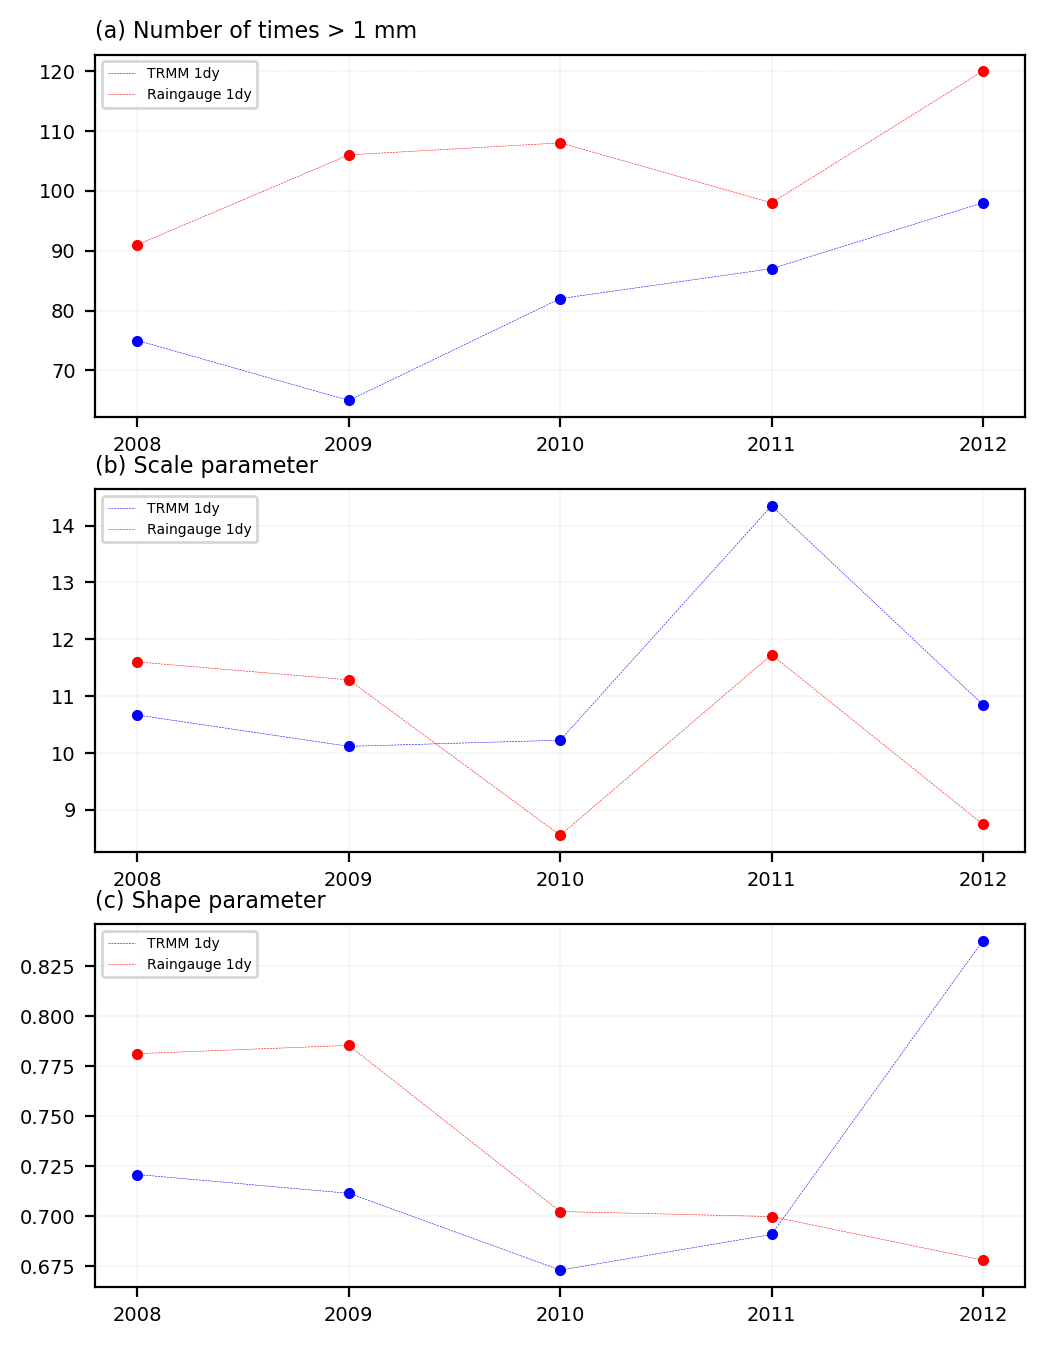

In [20]:
fig = plt.figure(figsize=(6,8),dpi=200)
gs = gridspec.GridSpec(3,1)

# ============================================================================================================================
# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0])

ax1.plot(YEARS_OBS, TRMM_NCW_1dy[:,0], '.b')
ax1.plot(TRMM_YEARS, TRMM_NCW_1dy[:,0], '--b', linewidth=0.2, label='TRMM 1dy')
ax1.plot(YEARS_OBS, NCW_1dy[:,0], '.r')
ax1.plot(YEARS_OBS, NCW_1dy[:,0], '--r', linewidth=0.2, c='r', label='Raingauge 1dy')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS.astype(int)[::1])
ax1.set_xticklabels(YEARS.astype(int)[::1])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(a) Number of times > 1 mm', loc='left', fontsize=8)

# ==============================================================================================
ax1 = plt.subplot(gs[1, 0])

ax1.plot(YEARS_OBS, TRMM_NCW_1dy[:,1], '.b')
ax1.plot(TRMM_YEARS, TRMM_NCW_1dy[:,1], '--b', linewidth=0.2, label='TRMM 1dy')
ax1.plot(YEARS_OBS, NCW_1dy[:,1], '.r')
ax1.plot(YEARS_OBS, NCW_1dy[:,1], '--r', linewidth=0.2, c='r', label='Raingauge 1dy')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS.astype(int)[::1])
ax1.set_xticklabels(YEARS.astype(int)[::1])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(b) Scale parameter', loc='left', fontsize=8)

# ==============================================================================================
ax1 = plt.subplot(gs[2, 0])

ax1.plot(YEARS_OBS, TRMM_NCW_1dy[:,2], '.b')
ax1.plot(TRMM_YEARS, TRMM_NCW_1dy[:,2], '--b', linewidth=0.2, label='TRMM 1dy')
ax1.plot(YEARS_OBS, NCW_1dy[:,2], '.r')
ax1.plot(YEARS_OBS, NCW_1dy[:,2], '--r', linewidth=0.2, c='r', label='Raingauge 1dy')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS.astype(int)[::1])
ax1.set_xticklabels(YEARS.astype(int)[::1])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(c) Shape parameter', loc='left', fontsize=8)

/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


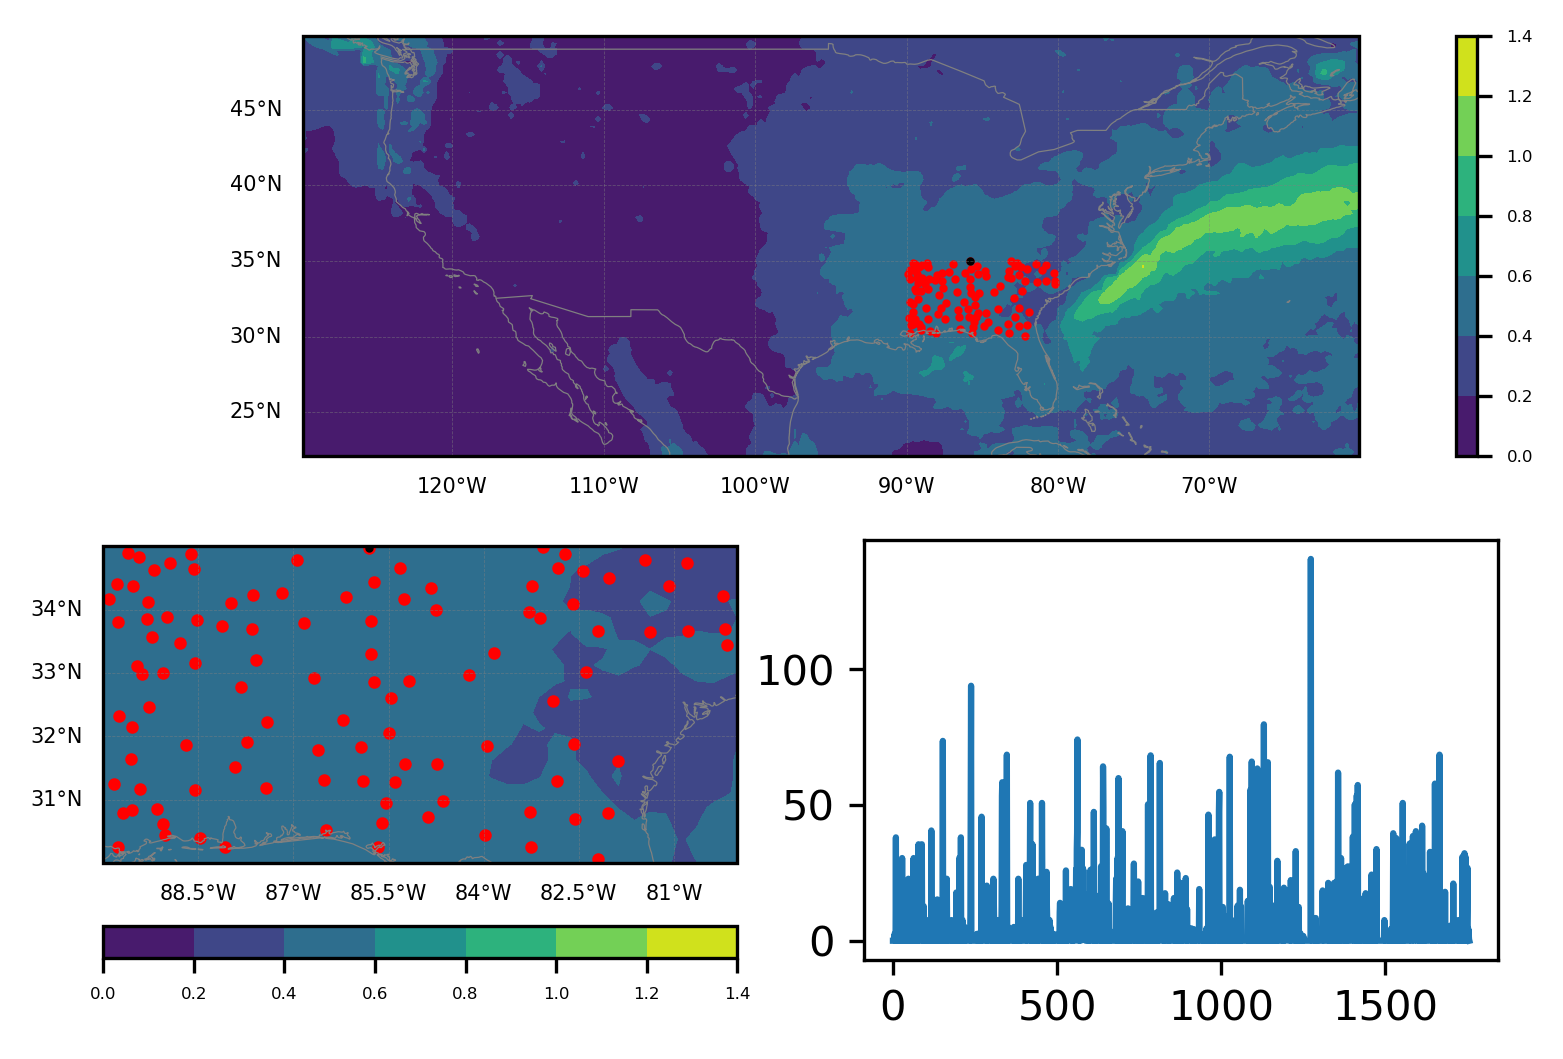

In [21]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(2,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0:], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')

a1 = ax1.contourf(lon2d, lat2d, dset.mean(dim='time').T)
ax1.scatter(lon_rain,lat_rain, s=1, c='r')
ax1.scatter(RAIN_lon, RAIN_lat, s=1, c='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, orientation='vertical', pad=0.07, fraction=0.03)
cbar.ax.tick_params(labelsize=4) 

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
ax1.set_extent([lo_limit_min, lo_limit_max, la_limit_min, la_limit_max], crs=proj)

a1 = ax1.contourf(lon2d, lat2d, dset.mean(dim='time').T)
ax1.scatter(lon_rain,lat_rain, s=4, c='r')
ax1.scatter(RAIN_lon, RAIN_lat, s=1, c='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, orientation='horizontal', pad=0.15, fraction=0.08)
cbar.ax.tick_params(labelsize=4) 

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 1])
ax1.plot(RAIN['PRCP'].values)

In [22]:
buffer = 0.50*npix*dx
eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
# eps = 0 # to make sure to include boundaires -> add an eps buffer
solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))
# XARRAY WITH VALUES LOADED IN MEMORY
box_3h = xrs.where(bcond, drop = True).load()

In [23]:
# downscaling:
print('Example: running the downscaling function')
init_time = time.time()
downres = down.downscale(box_3h, Tr, thresh=1.0, L0=0.0001, toll=0.005,
                            acf='mar', save_yearly=True,
                            maxmiss=maxmiss, clat=clat, clon=clon,
                            opt_method='genetic', plot=True)#maxmiss=36
end_time = time.time()
exec_time = end_time - init_time
print('Downscaling, execution time was = {} minutes'.format(exec_time/60))

Example: running the downscaling function
Downscaling Intermittency
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.0013190886841934538
differential_evolution step 2: f(x)= 0.001312850558702408
differential_evolution step 3: f(x)= 0.0012375134453185008
differential_evolution step 4: f(x)= 0.0012276064424293395
differential_evolution step 5: f(x)= 0.0012267362573536644
Polishing solution with 'L-BFGS-B'
integration domain is zero
Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters
Downscaling, execution time was = 1.116519304116567 minutes


In [24]:
downres['beta']

1.0901679463821412

/tmp/ipykernel_25385/4097655947.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(YEARS_OBS, NCW_1dy[:,0], '--r', linewidth=0.2, c='r', label='Raingauge 1dy')
/tmp/ipykernel_25385/4097655947.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(YEARS_OBS, NCW_1dy[:,1], '--r', linewidth=0.2, c='r', label='Raingauge 1dy')
/tmp/ipykernel_25385/4097655947.py:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(YEARS_OBS, NCW_1dy[:,2], '--r', linewidth=0.2, c='r', label='Raingauge 1dy')


Text(0.0, 1.0, '(c) Shape parameter')

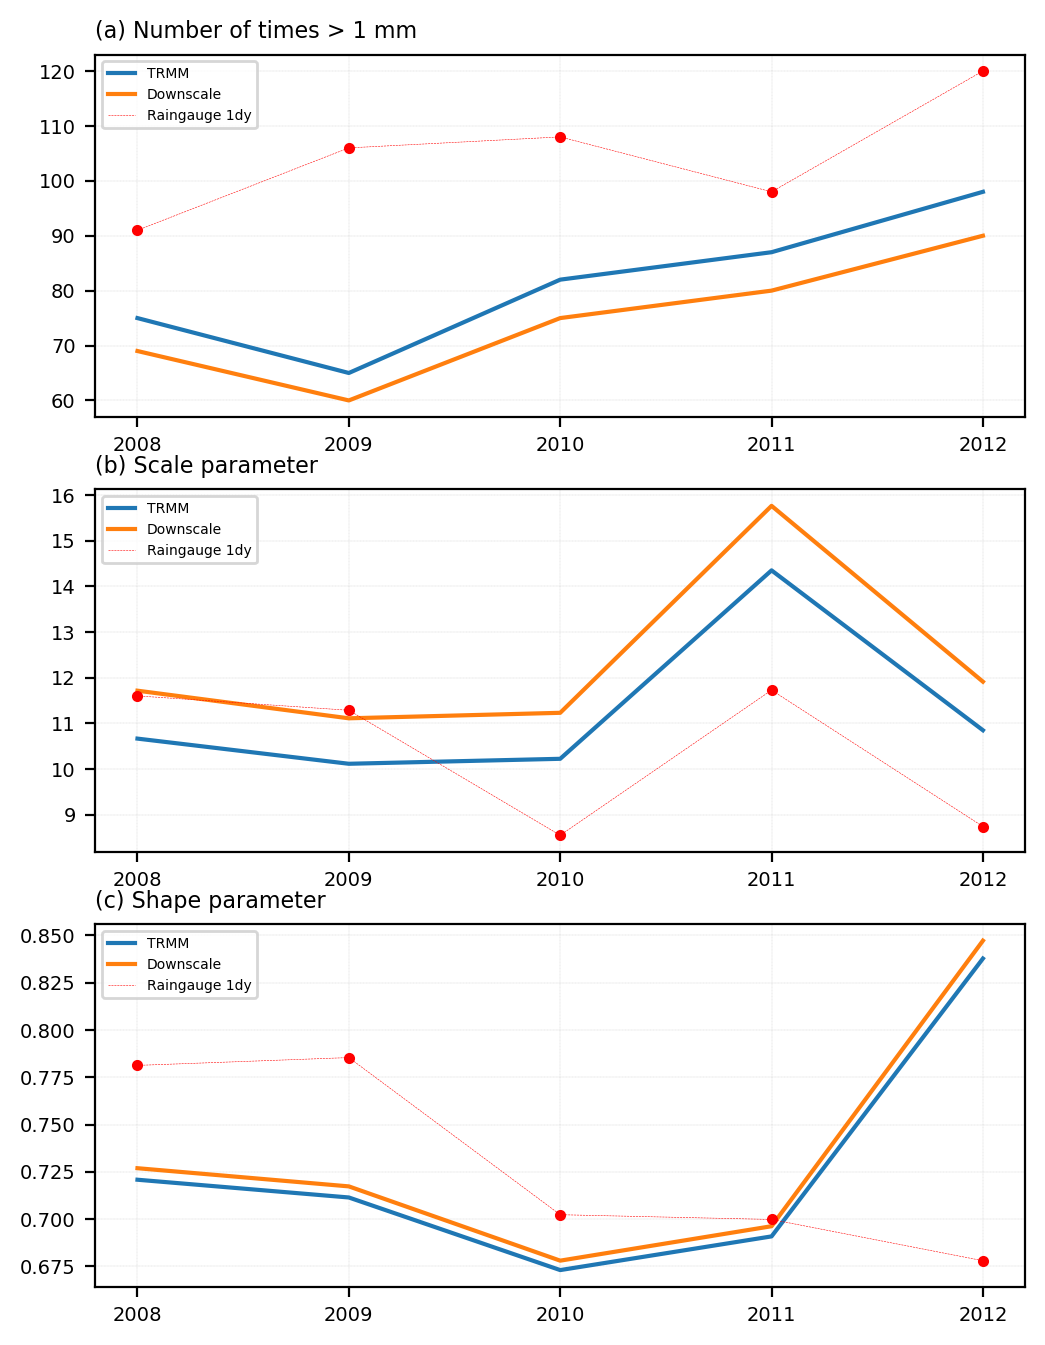

In [25]:
fig = plt.figure(figsize=(6,8),dpi=200)
gs = gridspec.GridSpec(3,1)

# ============================================================================================================================
# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0])

ax1.plot(YEARS[0:len(downres['NYs'])], downres['NYs'], label='TRMM')
ax1.plot(YEARS[0:len(downres['NYs'])], downres['NYd'], label='Downscale')
ax1.plot(YEARS_OBS, NCW_1dy[:,0], '.r')
ax1.plot(YEARS_OBS, NCW_1dy[:,0], '--r', linewidth=0.2, c='r', label='Raingauge 1dy')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS[0:len(downres['NYs'])].astype(int)[::1])
ax1.set_xticklabels(YEARS[0:len(downres['NYs'])].astype(int)[::1])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(a) Number of times > 1 mm', loc='left', fontsize=8)

# ==============================================================================================
ax1 = plt.subplot(gs[1, 0])

ax1.plot(YEARS[0:len(downres['NYs'])], downres['CYs'], label='TRMM')
ax1.plot(YEARS[0:len(downres['NYs'])], downres['CYd'], label='Downscale')
ax1.plot(YEARS_OBS, NCW_1dy[:,1], '.r')
ax1.plot(YEARS_OBS, NCW_1dy[:,1], '--r', linewidth=0.2, c='r', label='Raingauge 1dy')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS[0:len(downres['NYs'])].astype(int)[::1])
ax1.set_xticklabels(YEARS[0:len(downres['NYs'])].astype(int)[::1])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(b) Scale parameter', loc='left', fontsize=8)

# ==============================================================================================
ax1 = plt.subplot(gs[2, 0])

ax1.plot(YEARS[0:len(downres['NYs'])], downres['WYs'], label='TRMM')
ax1.plot(YEARS[0:len(downres['NYs'])], downres['WYd'], label='Downscale')
ax1.plot(YEARS_OBS, NCW_1dy[:,2], '.r')
ax1.plot(YEARS_OBS, NCW_1dy[:,2], '--r', linewidth=0.2, c='r', label='Raingauge 1dy')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS[0:len(downres['NYs'])].astype(int)[::1])
ax1.set_xticklabels(YEARS[0:len(downres['NYs'])].astype(int)[::1])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(c) Shape parameter', loc='left', fontsize=8)